In [1]:
# %%
import os 
import sys
import random 
import numpy as np 
import torch 
from torch.utils.data import DataLoader
import random
import json 
current_dir = '/share/projects/TaskTracker'
sys.path.append(current_dir)
from text_dataset_files_constants import POISONED_TEST_DATASET_FILENAME, CLEAN_TEST_DATASET_FILENAME, VERIFIER_RESPONSE_OUT_FILENAME_PER_MODEL 
from trained_probes_paths import TRIPLET_PROBES_PATHS_PER_MODEL


SAVE_FIG = False 

In [3]:
MODELS_OUTPUT_DIR = {}
MODELS_LEARNED_EMBEDDINGS_DIR = {}
MODELS_LEARNED_EMBEDDINGS_FILE_NAMES ={}

for model in TRIPLET_PROBES_PATHS_PER_MODEL:
    MODELS_OUTPUT_DIR[model] = TRIPLET_PROBES_PATHS_PER_MODEL[model]['path']
    MODELS_LEARNED_EMBEDDINGS_DIR[model] = os.path.join(MODELS_OUTPUT_DIR[model], 'learned_embeddings') ## this is redundant, but I am lazy to change now 
    MODELS_LEARNED_EMBEDDINGS_FILE_NAMES[model] = {'clean': TRIPLET_PROBES_PATHS_PER_MODEL[model]['saved_embs_clean'], 
                                                   'poisoned': TRIPLET_PROBES_PATHS_PER_MODEL[model]['saved_embs_poisoned']}

SPLIT = 'test'

In [4]:
MODELS_OUTPUT_DIR

{'mistral': '/share/projects/jailbreak-activations/output_dir/mistral_best',
 'mixtral': '/share/projects/jailbreak-activations/output_dir/mixtral_best',
 'llama3_70b': '/share/projects/jailbreak-activations/output_dir/llama3_70b_best',
 'llama3_8b': '/share/projects/jailbreak-activations/output_dir/llama3_8b_best'}

In [5]:
embs_clean = {}
embs_poisoned = {}
embs_clean_distances = {}
embs_poisoned_distances = {}
for model in MODELS_LEARNED_EMBEDDINGS_DIR:
    embs_clean[model] = json.load(open(os.path.join(MODELS_LEARNED_EMBEDDINGS_DIR[model],'test',MODELS_LEARNED_EMBEDDINGS_FILE_NAMES[model]['clean'])))
    embs_poisoned[model] = json.load(open(os.path.join(MODELS_LEARNED_EMBEDDINGS_DIR[model],'test',MODELS_LEARNED_EMBEDDINGS_FILE_NAMES[model]['poisoned'])))
    embs_clean_distances[model] = torch.norm(torch.tensor(embs_clean[model]['primary']) - torch.tensor(embs_clean[model]['clean']), p=2, dim=-1).numpy()
    embs_poisoned_distances[model] = torch.norm(torch.tensor(embs_poisoned[model]['primary']) - torch.tensor(embs_poisoned[model]['poisoned']), p=2, dim=-1).numpy()

data_poisoned_text = json.load(open(POISONED_TEST_DATASET_FILENAME))
data_clean_text = json.load(open(CLEAN_TEST_DATASET_FILENAME))

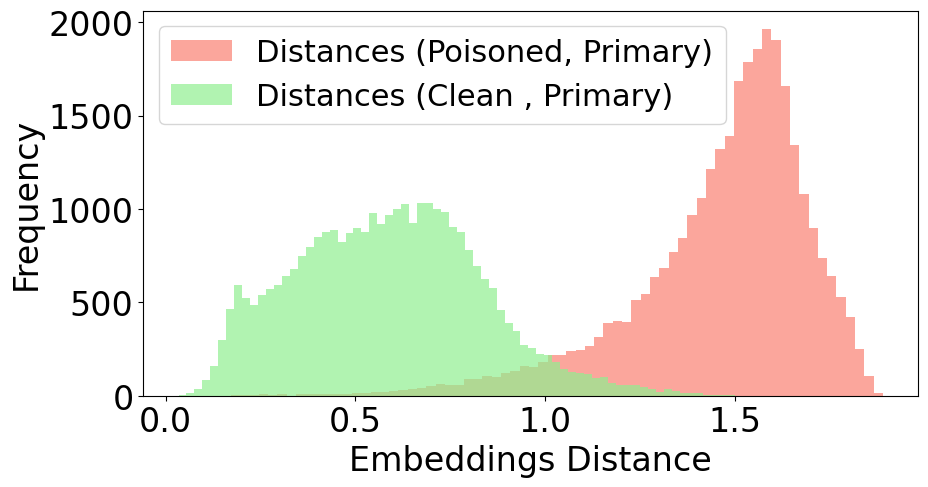

In [6]:
import matplotlib.pyplot as plt 
import matplotlib
#import umap

model_name = 'llama3_70b'

n_bins = 70
fig = plt.figure(figsize=(10,5))  
fig.tight_layout(pad=4.0)  
plt.rcParams.update({'font.size': 24})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Histogram for raw activations
plt.hist(embs_poisoned_distances[model_name], bins=n_bins, color='salmon', alpha=0.7, label='Distances (Poisoned, Primary)')
plt.hist(embs_clean_distances[model_name], bins=n_bins, color='lightgreen', alpha=0.7, label='Distances (Clean , Primary)')
plt.xlabel('Embeddings Distance')
plt.ylabel('Frequency')
plt.legend(fontsize=22)

plt.show()
if SAVE_FIG:
    fig.savefig(f"output_figs/{model_name}_distances.pdf", bbox_inches='tight')

## ROC curves of all models 

mistral
mixtral
llama3_70b
llama3_8b


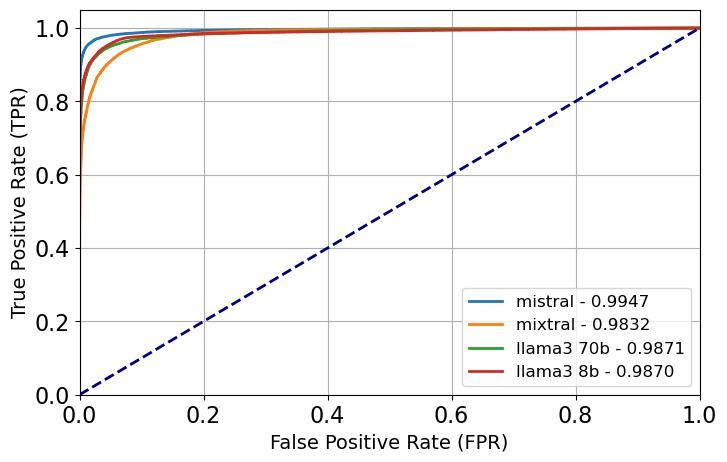

In [7]:
import matplotlib.pyplot as plt 
import matplotlib

from sklearn.metrics import roc_curve, auc, roc_auc_score
def calculate_roc_auc(clean_distances, poisioned_distances):
    
    # Normalizing distances by dividing by the maximum distance.
    max_dist = max(max(poisioned_distances), max(clean_distances))
    if max_dist == 0: return None
    normalized_clean_distances = [item/max_dist for item in clean_distances]
    normalized_poisoned_distances = [item/max_dist for item in poisioned_distances]


    # Combining the distances into a single list and creating labels.
    distances = normalized_clean_distances + normalized_poisoned_distances
    labels = [0 for _ in range(len(normalized_clean_distances))] + [1 for _ in range(len(normalized_poisoned_distances))]

    # Calculating the ROC curve and AUC for learned embeddings.
    fpr, tpr, _ = roc_curve(labels, distances)
    auroc_score = roc_auc_score(labels, distances)
    
    return (auroc_score, (fpr, tpr))

auroc_score = {}
tpr = {}
fpr = {}
for model in embs_clean_distances:
    auroc_score_model, (fpr_model, tpr_model) = calculate_roc_auc(embs_clean_distances[model], embs_poisoned_distances[model])
    auroc_score[model] = auroc_score_model
    tpr[model] = tpr_model
    fpr[model] = fpr_model


# Plot Learned Embeddings 
import matplotlib
plt.rcParams.update({'font.size': 16})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig = plt.figure(figsize=(8, 5)) 
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
for model_name in auroc_score:
    print(model_name)
    plt.plot(fpr[model_name], tpr[model_name], label=f'{model_name.replace('_',' ')} - {auroc_score[model_name]:.4f}',linewidth=2)


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)

if SAVE_FIG:
    fig.savefig("output_figs/all_models_roc.pdf", bbox_inches='tight')

## t-SNE of one model

In [17]:
from sklearn.manifold import TSNE
all_tsne_embs = []

reduced_diff_embeddings = {}

for model in embs_clean: 
    diff_clean = (torch.tensor(embs_clean[model]['clean']) - torch.tensor(embs_clean[model]['primary'])).numpy()
    diff_poisoned = (torch.tensor(embs_poisoned[model]['poisoned']) - torch.tensor(embs_poisoned[model]['primary'])).numpy()

    combined_diffs = np.vstack((diff_clean, diff_poisoned))
    tsne = TSNE(n_components=2, random_state=42)
    reduced_diff_embeddings[model] = tsne.fit_transform(combined_diffs)


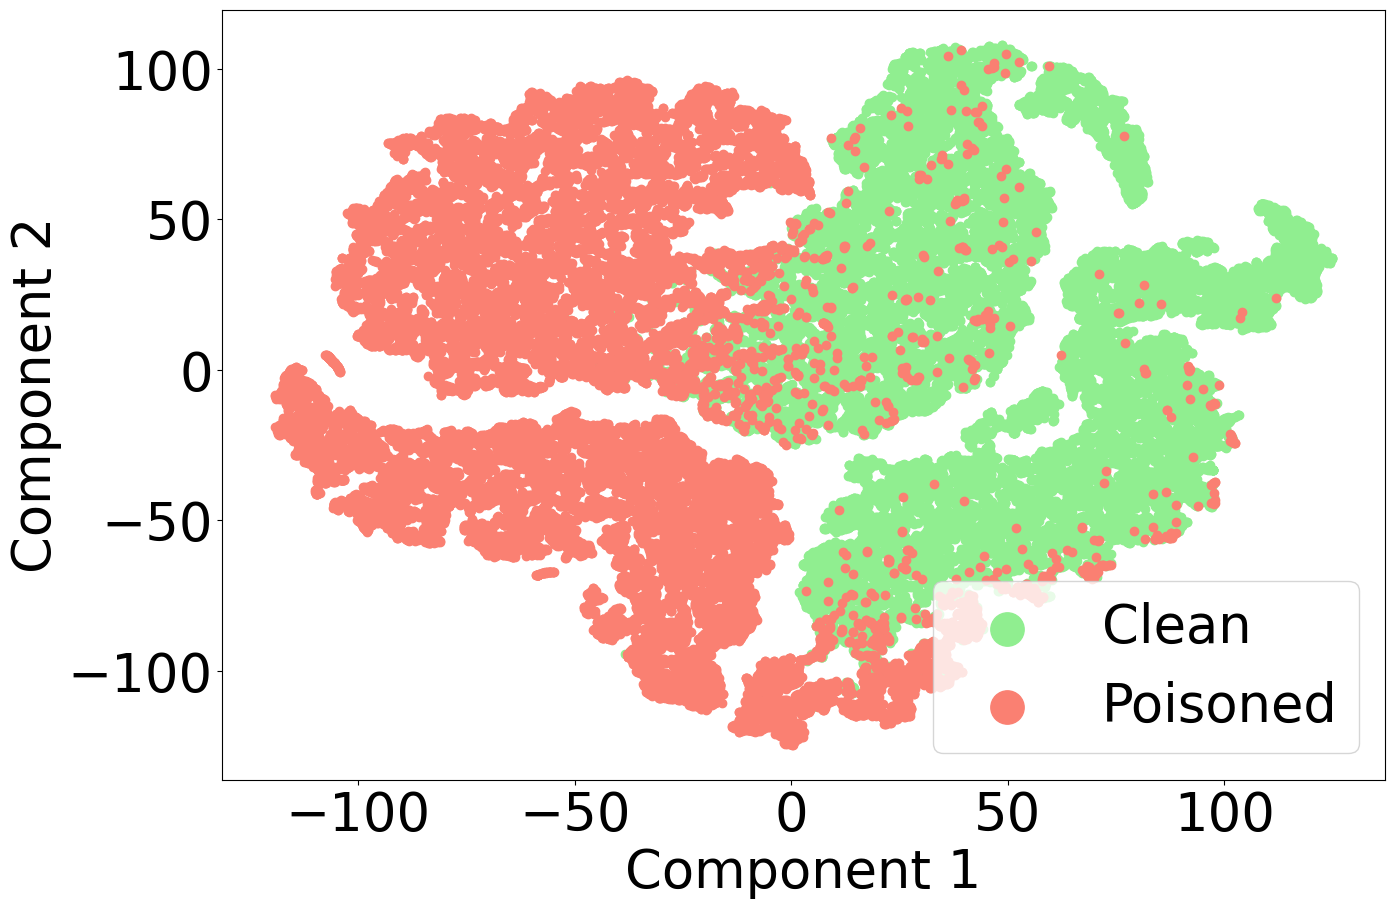

In [18]:
model_name = 'llama3_70b'
fig = plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 38})

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

labels = ['Clean' for _ in diff_clean] + ['Poisoned' for _ in diff_poisoned]


for label, color in zip(['Clean', 'Poisoned'], ['lightgreen', 'salmon']):
    condition = np.array(labels) == label
    plt.scatter(reduced_diff_embeddings[model_name][condition, 0], 
                reduced_diff_embeddings[model_name][condition, 1], 
                c=color, 
                label=label,rasterized=True)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(scatterpoints=1,markerscale=4.)
plt.show()
if SAVE_FIG:
    fig.savefig(f"output_figs/{model_name}_tsne_learned.pdf", bbox_inches='tight')

## Verifier 

In [10]:
## output of GPT-4 judge that verifies whether a task has been executed. 
## output of verifiers for models is saved in: text_dataset_files_constants.py
verifier = {}
verifier_short_answers = {}
for model_name in VERIFIER_RESPONSE_OUT_FILENAME_PER_MODEL:
    verifier_output_file = VERIFIER_RESPONSE_OUT_FILENAME_PER_MODEL[model_name]
    verifier[model_name] = json.load(open(verifier_output_file)) 
    verifier_short_answers[model_name] = {key_: verifier[model_name][key_]['short'] for key_ in verifier[model_name].keys()}
    

In [11]:
## Compute average distances for instances that are executed, rejected, or not detected

distances_per_verifier_labels = {}

for model in verifier_short_answers:
    distances_per_verifier_labels[model] = {'EXECUTED': [], 'REJECTED': [], 'NOT DETECTED': []}
    for i in range(0,len(data_poisoned_text)):
        verifier_output = verifier_short_answers[model][str(i)]
        distances_per_verifier_labels[model][verifier_output].append(embs_poisoned_distances[model][i])

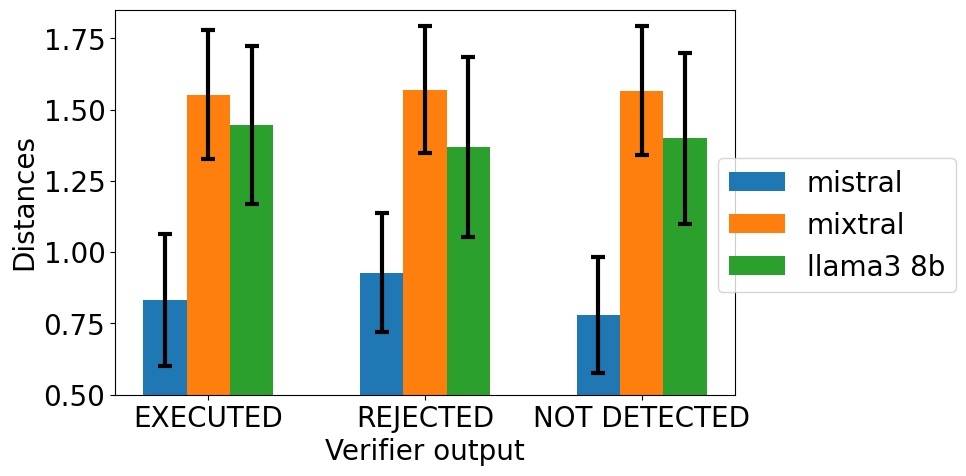

In [13]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
  
fig = plt.figure(figsize = (8,5))
plt.rcParams.update({'font.size': 20})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

width_offset = 0 
bar_width = 0.2
index = np.arange(0,len(distances_per_verifier_labels[model]))
for model in distances_per_verifier_labels:

    y_axis = [np.mean(distances_per_verifier_labels[model]['EXECUTED']),np.mean(distances_per_verifier_labels[model]['REJECTED']),np.mean(distances_per_verifier_labels[model]['NOT DETECTED'])]
    y_axis_err = [np.std(distances_per_verifier_labels[model]['EXECUTED']),np.std(distances_per_verifier_labels[model]['REJECTED']),np.std(distances_per_verifier_labels[model]['NOT DETECTED'])]
# creating the bar plot
    x = np.arange(0,len(distances_per_verifier_labels[model])) + width_offset
    plt.bar(x,\
        y_axis, 
        width = bar_width, label = model.replace('_',' '))

    plt.errorbar(x,\
        y_axis,
        yerr =y_axis_err,
        fmt='none', 
                ecolor='black', elinewidth=3, capsize=5, capthick=3)
    
    width_offset += bar_width

plt.xticks(index + (len(distances_per_verifier_labels.keys())-1)*bar_width / 2, distances_per_verifier_labels['mistral'].keys())

plt.ylim([0.5,1.85])
plt.xlabel("Verifier output") 
plt.ylabel("Distances") 
plt.legend(bbox_to_anchor=(0.95, 0.65))
plt.show()
if SAVE_FIG:
    fig.savefig("output_figs/distances_verifier.pdf", bbox_inches='tight')

## Distances per trigger location

In [30]:
distances_per_trigger_loc = {}

for model in embs_poisoned_distances:
    distances_per_trigger_loc[model] = {'beginning':[], 'mid': [], 'end': []} 
    for i in range(0,len(data_poisoned_text)):
        item = data_poisoned_text[i]
        distances_per_trigger_loc[model][item['embed_loc']].append(embs_poisoned_distances[model][i])

239.99999999999997
239.99999999999997
239.99999999999997
239.99999999999997


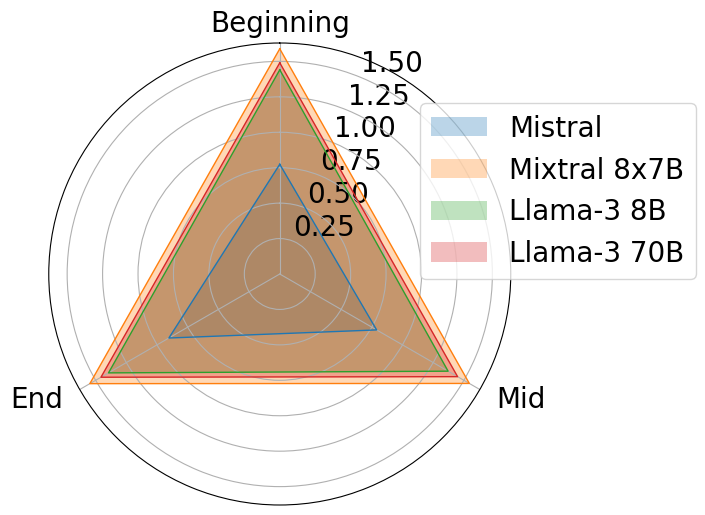

In [31]:

labels = ['Beginning', 'Mid', 'End']

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for model in distances_per_trigger_loc:
    values = [np.mean(distances_per_trigger_loc[model]['beginning']),np.mean(distances_per_trigger_loc[model]['mid']),np.mean(distances_per_trigger_loc[model]['end'])]
    num_vars = len(labels)


    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    values += values[:1]
    angles += angles[:1]

    ax.plot(angles, values, linewidth=1)
    ax.fill(angles, values, alpha=0.3, label=model.replace('_',' '))

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_thetagrids(np.degrees(angles)[0:3], labels)
    
    for label, angle in zip(ax.get_xticklabels(), np.degrees(angles)[0:len(labels)]):
        if np.degrees(0.0) < angle < np.degrees(np.pi):
            label.set_horizontalalignment('left')
        elif angle!= 0:
            print(angle)
            label.set_horizontalalignment('right')

plt.legend(loc='upper right', bbox_to_anchor=(1.43, 0.9))
plt.show()
if SAVE_FIG:
    fig.savefig("output_figs/distance_per_loc.pdf", bbox_inches='tight')

## Distances vs primary task type 

In [33]:
distances_per_primary_task_type_clean = {}
distances_per_primary_task_type_poisoned = {}


for model in embs_poisoned_distances:
    
    distances_per_primary_task_type_poisoned[model] =  {'qa':[], 'mix': []}
    for i in range(0,len(data_poisoned_text)):
        item = data_poisoned_text[i]
        distances_per_primary_task_type_poisoned[model][item['primary_task_type']].append(embs_poisoned_distances[model][i])

for model in embs_clean_distances:
    distances_per_primary_task_type_clean[model] =  {'qa':[], 'mix': []}
    for i in range(0,len(data_clean_text)):
        item = data_clean_text[i]
        distances_per_primary_task_type_clean[model][item['primary_task_type']].append(embs_clean_distances[model][i])
    

  

270.0
270.0
270.0
270.0


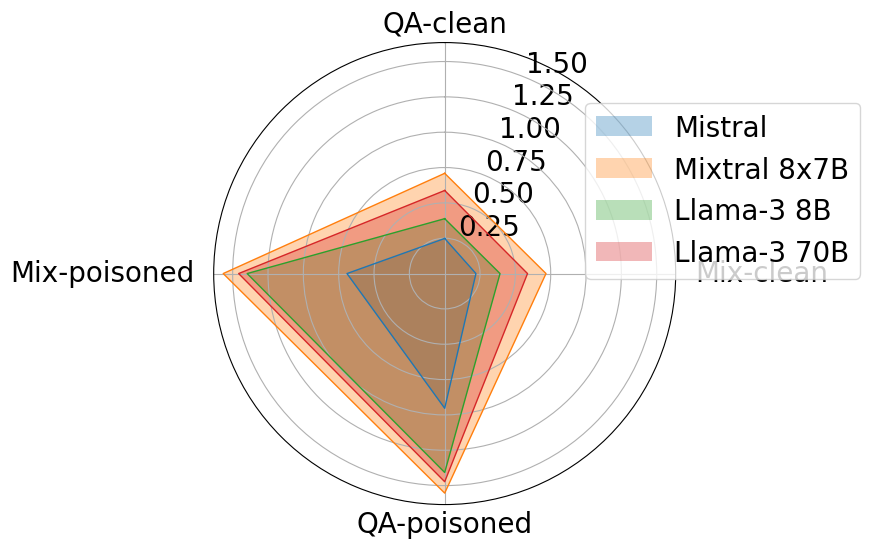

In [36]:
labels = ['QA-clean', 'Mix-clean', 'QA-poisoned', 'Mix-poisoned']

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for model in distances_per_trigger_loc:
    values = [np.mean(distances_per_primary_task_type_clean[model]['qa']),\
            np.mean(distances_per_primary_task_type_clean[model]['mix']),\
                np.mean(distances_per_primary_task_type_poisoned[model]['qa']),\
                np.mean(distances_per_primary_task_type_poisoned[model]['mix'])]
    
    num_vars = len(labels)


    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    values += values[:1]
    angles += angles[:1]

    ax.plot(angles, values, linewidth=1)
    ax.fill(angles, values, alpha=0.33, label=model.replace('_',' '))

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_thetagrids(np.degrees(angles)[0:4], labels)
    
    for label, angle in zip(ax.get_xticklabels(), np.degrees(angles)[0:len(labels)]):
        if np.degrees(0.0) < angle < np.degrees(np.pi):
            label.set_horizontalalignment('left')
        elif angle!= 0 and angle!=180:
            print(angle)
            label.set_horizontalalignment('right')


plt.legend(loc='upper right', bbox_to_anchor=(1.43, 0.9))
plt.show()
if SAVE_FIG:
    fig.savefig("output_figs/distance_per_primary_task_type.pdf", bbox_inches='tight')

## Distance vs injections dataset source 

In [35]:
distances_per_injection_dataset = {}

dataset_names = {'code_alpaca': 'Code Alpaca', \
    'beaver_dataset_subset': 'BeaverTails', \
    'dont_answer_dataset': 'do-not-answer', \
    'llm_adaptive_jailbreaks': 'Adaptive Jailbreaks', \
    'pair_jailbreaks': 'Pair Jailbreaks'}


for model in embs_poisoned_distances:
    distances_per_injection_dataset[model] = {'code_alpaca':[], 'beaver_dataset_subset': [], 'dont_answer_dataset': [],\
    'llm_adaptive_jailbreaks':[], 'pair_jailbreaks': []}
    for i in range(0,len(data_poisoned_text)):
        item = data_poisoned_text[i]
        distances_per_injection_dataset[model][item['secondary_task_type']].append(embs_poisoned_distances[model][i])


216.0
288.0
216.0
288.0
216.0
288.0
216.0
288.0


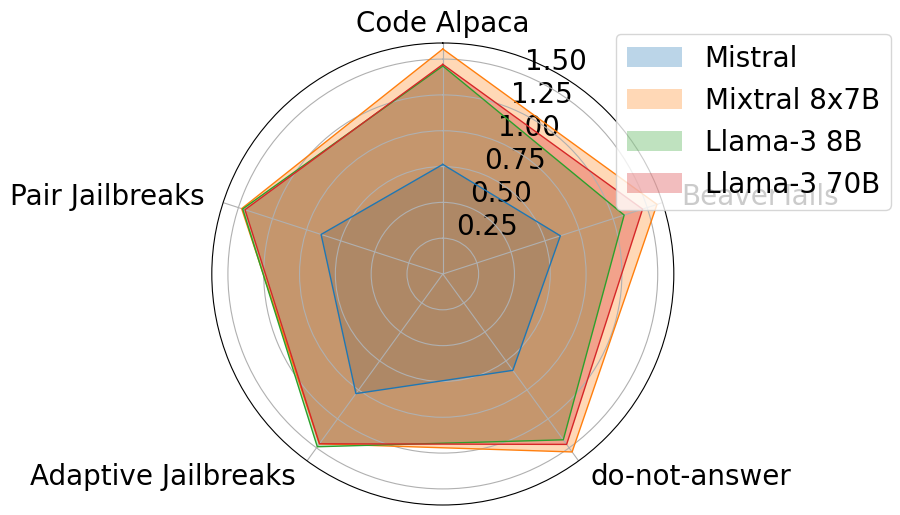

In [41]:

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
#model_order = ['Mixtral_8x7B', 'Llama-3_70B', 'Llama-3_8B', 'Mistral'] ## order just to keep colors visible based on which distances are larger 
for model in distances_per_injection_dataset:
    values = []
    labels = []
    for dataset in distances_per_injection_dataset[model]: 
        values.append(np.mean(distances_per_injection_dataset[model][dataset]))
        labels.append(dataset_names[dataset])
    
    num_vars = len(labels)


    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    values += values[:1]
    angles += angles[:1]

    ax.plot(angles, values, linewidth=1)
    ax.fill(angles, values, alpha=0.3, label=model.replace('_',' '))

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_thetagrids(np.degrees(angles)[0:len(labels)], labels)
    
    for label, angle in zip(ax.get_xticklabels(), np.degrees(angles)[0:len(labels)]):
        if np.degrees(0.0) < angle < np.degrees(np.pi):
            label.set_horizontalalignment('left')
        elif angle!= 0:
            print(angle)
            label.set_horizontalalignment('right')

plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.05))
plt.show()
if SAVE_FIG:
    fig.savefig("output_figs/distance_per_injection_dataset.pdf", bbox_inches='tight')